In [1]:
#import the required library packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import csv
import imblearn as im
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,auc
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
#import the train dataset
ds = pd.read_csv('../DSCaseStudy (1)/train.csv')

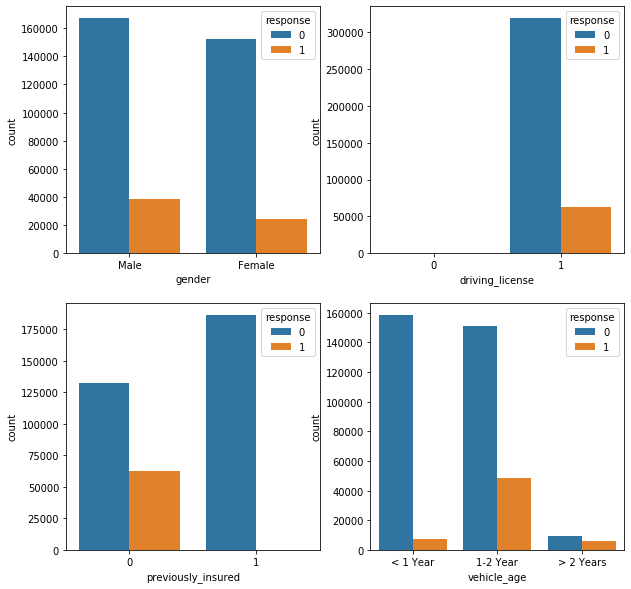

In [3]:
#EDA performed to understand the training dataset
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(ax=axes[0,0],x='gender',hue='response',data=ds) 
sns.countplot(ax=axes[0,1],x='driving_license',hue='response',data=ds) 
sns.countplot(ax=axes[1,0],x='previously_insured',hue='response',data=ds) 
sns.countplot(ax=axes[1,1],x='vehicle_age',hue='response',data=ds) 

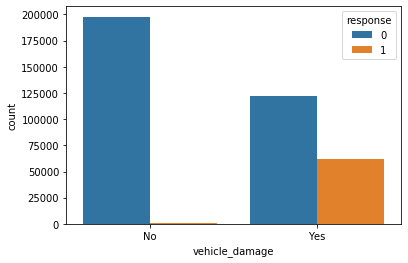

In [4]:
sns.countplot(x='vehicle_damage',hue='response',data=ds)

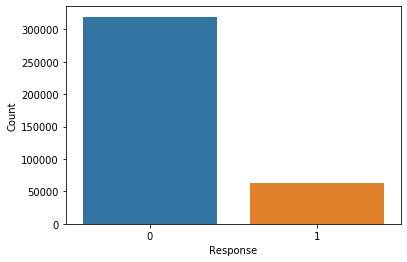

In [5]:
Resp_count = ds.loc[:,"response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(Resp_count.index , Resp_count.values)

<BarContainer object of 66 artists>

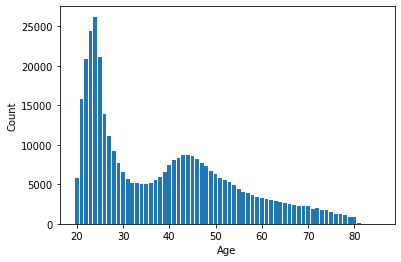

In [6]:
age_count = ds.loc[:,"age"].value_counts().rename('Count')
plt.xlabel("Age")
plt.ylabel('Count')
plt.bar(age_count.index , age_count.values)

[(0, 2000)]

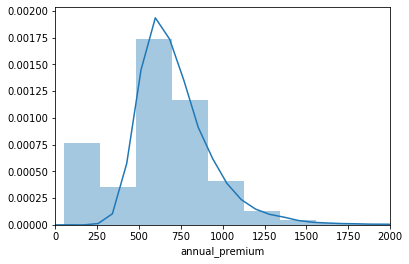

In [7]:
sns.distplot(ds['annual_premium']).set(xlim = (0,2000))

In [8]:
# Data pre-processing and binning to prepare the data for modelling
def data_prep(ds):

    ds= ds.drop(columns=['cust_id','policy_sales_channel', 'days_since_insured'])

    ds=pd.get_dummies(ds,columns=['gender'] ,prefix='gender')

    ds=pd.get_dummies(ds,columns=['vehicle_damage'] ,prefix='damage')

    ds=pd.get_dummies(ds,columns=['driving_license'] ,prefix='license')

    ds=pd.get_dummies(ds,columns=['previously_insured'] ,prefix='prev_insured')

    ds["age"] = pd.cut(ds['age'], bins=[0, 30, 40, 50, 100])

    ds['age']= ds['age'].cat.codes

    ds['annual_premium'] = pd.cut(ds['annual_premium'], bins=[0, 500, 1500, np.inf])

    ds['annual_premium']= ds['annual_premium'].cat.codes

    ds['vehicle_age'] =ds['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

    ds.drop(columns=['region_code'],inplace= True)

    return ds

ds1=data_prep(ds)

In [9]:
#Defining relevant parameters
params = ['age','vehicle_age','annual_premium',"gender_Female","gender_Male","damage_No","damage_Yes",

"license_0","license_1" ,"prev_insured_0", "prev_insured_1"]

In [10]:
# Split-out validation dataset
array = ds1.values
X = array[:,0:11]
y = array[:,11]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.30, random_state=1)

In [11]:
ros = RandomOverSampler(random_state=0)

In [12]:
#Oversampling the dataset and fitting on the defined parameters
X_train, Y_train = ros.fit_resample(ds1[params],ds1['response'])

In [13]:
#Determining model accuracy and F1 score
def performance_met(model,X_train,Y_train,X_validation,Y_validation):

    acc_train=accuracy_score(Y_train, model.predict(X_train))

    f1_train=f1_score(Y_train, model.predict(X_train))

    acc_validation=accuracy_score(Y_validation, model.predict(X_validation))

    f1_validation=f1_score(Y_validation, model.predict(X_validation))
    
    print("train score: accuracy:{} f1:{}".format(acc_train,f1_train))

    print("validation score: accuracy:{} f1:{}".format(acc_validation,f1_validation))

In [14]:
#Fitting the model on logistic regression
model = LogisticRegression()
model.fit(X_train,Y_train) 
performance_met(model,X_train,Y_train,X_validation,Y_validation)

train score: accuracy:0.8151057883981687 f1:0.8418745375010538
validation score: accuracy:0.7521086465411219 f1:0.6607296342278673


In [15]:
#Fitting the model on Random Forest Classifier
Forest= RandomForestClassifier(random_state=1) 
Forest.fit(X_train,Y_train) 
performance_met(Forest,X_train,Y_train,X_validation,Y_validation)

train score: accuracy:0.8215491639884464 f1:0.8416929357369012
validation score: accuracy:0.5407206468551292 f1:0.11553256177246235


In [16]:
#Fitting the model on Decision tree classifier
model_DT=DecisionTreeClassifier(random_state=1) 
prdt=model_DT.fit(X_train,Y_train) 
performance_met(model_DT,X_train,Y_train,X_validation,Y_validation)

train score: accuracy:0.8215491639884464 f1:0.8416929357369012
validation score: accuracy:0.734061946671086 f1:0.6268130576873646


In [17]:
#predicts the test dataset class labels of each sample
predicted_classes = model_DT.predict(X_validation)

#predicts the probability of each sample in the test data
predicted_prob=model_DT.predict_proba(X_validation)

#to get the accuracy metrics
print(classification_report(Y_validation,predicted_classes))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     58553
           1       1.00      0.46      0.63     56094

    accuracy                           0.73    114647
   macro avg       0.83      0.73      0.71    114647
weighted avg       0.83      0.73      0.71    114647



In [ ]:
#Feature importance in training the model 
feat_importances = pd.Series(model_DT.feature_importances_, index=params)
feat_importances.nlargest(5).plot(kind='barh')

In [19]:
D_test = pd.read_csv('../DSCaseStudy (1)/test.csv')

In [20]:
dtst = data_prep(D_test)

In [21]:
preds = model_DT.predict_proba(dtst)

In [22]:
preds_1 = model_DT.predict(dtst)

In [23]:
result = [[x,y] for x,y in zip(D_test.iloc[:,0],[a[1] for a in list(preds)])]

In [24]:
# field names 
fields = ['cust_id', 'propensity'] 
    
with open('propensity.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(result)
res = pd.read_csv('propensity.csv')
def try_cutoff(x):
    try:
        return round(float(x), 3)
    except Exception:
        return x
column = 'propensity'
for column in res.columns:
    res[column] = res[column].map(try_cutoff)
res.to_csv('propensity.csv', index=False)